<a href="https://colab.research.google.com/github/cgpilapanta/timeseries/blob/main/TEG_Cap_03_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**CAPÍTULO 03. ANÁLISE TEMPORAL**
---
*   Autor: Christian G. Pilapanta A.
*   Data : Outuubro de 2024
*   Lotação: Departamento de Geomática - UFPR / Laboratorio de Geodésia Espacial e Hidrografia

---

**Definição do entorno de trabalho e Importação de dados**

In [175]:
#Bibliotecas de Python necessárias para rodar o código
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm

from scipy import stats
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import het_breuschpagan
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.api import SimpleExpSmoothing

In [196]:
# Importar (clonar) repósitorio de GitHub
!rm -r timeseries
!git clone https://github.com/cgpilapanta/timeseries.git

Cloning into 'timeseries'...
remote: Enumerating objects: 235, done.
remote: Counting objects: 100% (235/235), done.
remote: Compressing objects: 100% (230/230), done.
remote: Total 235 (delta 91), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (235/235), 31.61 MiB | 6.06 MiB/s, done.
Resolving deltas: 100% (91/91), done.


## **3.2. Transformações**

De acordo com Morettin, P. & Toloi, C. (2014), há, basicamente, duas razões para transformar os dados originais de uma série temporal:

1.   Estabilizar a variância dos dados.
2.   Tornar o efeito sazonal aditivo.
3.   Obter uma distribuição para os dados mais simétrica e próxima da normal.

Um exemplo de séries que precisam ser transformadas antes de poder ser analisadas estatísticamente, são aquelas séries com tendências e/ou variâncias crescentes á medida que o tempo passa. Neste caso, por exemplo, o uso de uma transformação logarítimica pode ser adequada.

**Importante:**

No entanto, as transformações de séries possuim algumas restrições a ser consideradas. Neste sentido, é importante citar algumas pesquisas com relação a este tema:

*   Nelson (1976) conclui que as transformações não melhoram a qualidade da previsão.
*   Granger e Newbold (1976) mostram que as previsões dos antilogaritmos dos dados transformados são estimadores viesados, pelo qual, deveriam serem ajustados (i.e. após a transformação, um víes é introduzido nas previsões).
*   Granger e Newbold (1976) também observam que a heteroscedasticidade não afeta a adequação da previsão, pois ela não implica em estimadores viesados, como no caso da regressã múltipla.
*   Plosser (1979) observa que quando se tem um conjunto de dados que apresenta um padrão sazonal, é muito comum fazer um ajustamento sazonal dos dados e depois usar um modelo não-sazonal para se fazer a previsão. Não entanto, pode ser preferível fazer a previsão usando diretamente o modelo sazonal ao invés de ajustar sazonalmente a série.

### **3.2.1. Transformações lineares e não-lineares**

Vimos, na seção 3.1.3. que para tornar uma série estacionária podemos tomar diferenças, de acordo com o modelo:

$$\Delta ^{n}Z\left ( t \right )=\Delta \left [ \Delta^{n-1} Z\left ( t \right ) \right ]$$

No entanto, as vezes pode ser necessário aplicar antes, à série original, alguma transformação não-linear, como a logaritmica ou, em geral, uma transformação da forma:

$$Z_{t}^{\left ( \lambda  \right )}=\left\{\begin{matrix}
\frac{Z_{t}^{\lambda }-c}{\lambda } & se \lambda \neq 0, \\
log Z_{t} & se \lambda =0  \\
\end{matrix}\right.$$

chamada de *transformação de Box-Cox*. Aqui $\lambda$ e $c$ são parâmetros a serem estimados.

**Importante:**

A transformação logarítmica é apropiada se o desvio padrão da série (ou outra medida de dispersão) for proporcional a média.

### **3.2.2. Cómo saber escolher a transformação?**

Para ter uma idéia do tipo de transformação que é adequada, pode-se utilizar um gráfico que traz no eixo das abcissas **médias de subconjuntos de observações da série original** e no eixo das ordenadas a **amplitude de cada um desses subconjuntos**.

Desta forma, se $Z_{1},\cdots ,Z_{k}$ for um subconjunto de $Z_t$ com $k$ observações, calculamos:

$$\overline{Z}=\frac{1}{k}\sum_{i=1}^{k}Z_{t_{i}}$$

e

$$w=max\left ( Z_{t_{i}} \right )-min\left ( Z_{t_{i}} \right )$$

que são medidas de posição e variabiliade respectivamente. O par $\left ( \overline{Z},w \right )$ será um **ponto** do gráfico.

**Importante:**

O número de elementos em cada sub-série pode ser igual ao período, no caso de séries sazonais.

**Interpretação:**

<center><img src=https://iili.io/dsODTyQ.md.jpg width="400"></center>

<center>Figura 1. Gráfico amplitude x média com valores de $\lambda$</center>

<center>Fonte: Jenkins (1979)</center>


* Se $w$ independer de $\overline{Z}$, obteremos pontos espalhados ao redor de uma reta paralela ao eixo das abcissas. Neste caso não haverá necessidade de transformação.
* Se $w$ for diretamente proporcional a $\overline{Z}$, a transformação logarítmica é apropriada.
* Nos outros casos, diversas curvas serão geradas, sendo necessário implementar outro tipo de transformações mais elaboradas.

No caso de querer obter uma distribuição mais simétrica e próxima da normal, Hinkley (1977) sugere que se calcule a média, mediana e um estimador de escala robusto (i.e. desvio padrão) e, então, para a transformação $Z_{t}^{\left ( \lambda  \right )}$, com valores para $\lambda$ de: ..., -3, -2, -1, -1/2, -1/4, 0, 1/4, 1/2, 1, 2, 3, ..., escolha-se o valor de $\lambda$ que minimize a relação:

$$d_{\lambda }=\frac{\left|media- mediana \right|}{estimador}$$

que pode ser vista como uma medida de assimetria (i.e. numa distribuição simétrica, $d_{\lambda }=0$).

#### Exemplo 01. Série de coordenadas. Análise das médidas de posição e estabilidade
---
A. Importar o conjunto de dados

In [177]:
# Definir nomes de cada coluna
header = ['Station','Date','Decimal Year','MJD','GPS Week','Week Day','Longitude','East','North','Up','Antenna Height','dE','dN','dU','corrEN','corrEU','corrNU']

# Importar arquivo de texto (dataframe Pandas)
df_gps = pd.read_csv("/content/timeseries/datasets/ngl/UFPR.tenv", names=header, delim_whitespace=True)

# Apresentar tabela de dados
df_gps.head()

,Station,Date,Decimal Year,MJD,GPS Week,Week Day,Longitude,East,North,Up,Antenna Height,dE,dN,dU,corrEN,corrEU,corrNU
0,UFPR,96DEC14,1996.9528,50431,883,6,-49.2,-3113.36397,-2.815723e+06,925.75507,0.155,0.00098,0.00096,0.00441,0.03008,0.00245,0.07710
1,UFPR,96DEC15,1996.9555,50432,884,0,-49.2,-3113.36524,-2.815723e+06,925.75194,0.155,0.00097,0.00099,0.00439,0.00931,0.04183,0.05181
2,UFPR,96DEC16,1996.9582,50433,884,1,-49.2,-3113.36607,-2.815723e+06,925.74076,0.155,0.00100,0.00098,0.00442,-0.03754,0.00249,0.06097
3,UFPR,96DEC17,1996.9610,50434,884,2,-49.2,-3113.36379,-2.815723e+06,925.74558,0.155,0.00103,0.00105,0.00468,0.02839,0.03994,0.04081
4,UFPR,96DEC18,1996.9637,50435,884,3,-49.2,-3113.36239,-2.815723e+06,925.75661,0.155,0.00100,0.00096,0.00427,-0.03851,0.00671,0.02549


B. Plotar os dados

In [178]:
# Ativar "plotly" para geração de gráficos interativos
pd.options.plotting.backend = "plotly"

# Geração da série de coordenadas
fig = df_gps.plot(title = "UFPR Continuous Monitoring GNSS Station. North Component", x = 'Decimal Year', y = 'North')

# Apresentar série de tempo
fig.show()

C. Amostragem do conjunto de dados

In [179]:
# Criar coluna com a parte inteira do ano decimal
df_gps['Year'] = df_gps['Decimal Year'].apply(lambda x: str(x)[:4])

# Agrupar tabela pela coluna "Year"
grouped = df_gps.groupby(df_gps.Year)

# Criar dataframes por ano
df_gps_2010 = grouped.get_group("2010")
df_gps_2011 = grouped.get_group("2011")
df_gps_2012 = grouped.get_group("2012")
df_gps_2013 = grouped.get_group("2013")
df_gps_2014 = grouped.get_group("2014")
df_gps_2015 = grouped.get_group("2015")
df_gps_2016 = grouped.get_group("2016")
df_gps_2017 = grouped.get_group("2017")
df_gps_2018 = grouped.get_group("2018")
df_gps_2019 = grouped.get_group("2019")
df_gps_2020 = grouped.get_group("2020")
df_gps_2021 = grouped.get_group("2021")
df_gps_2022 = grouped.get_group("2022")
df_gps_2023 = grouped.get_group("2023")

D. Cálculo das medidas de posição e variabilidade

In [180]:
# Cálculo da média
z_2010 = df_gps_2010['North'].mean()
z_2011 = df_gps_2011['North'].mean()
z_2012 = df_gps_2012['North'].mean()
z_2013 = df_gps_2013['North'].mean()
z_2014 = df_gps_2014['North'].mean()
z_2015 = df_gps_2015['North'].mean()
z_2016 = df_gps_2016['North'].mean()
z_2017 = df_gps_2017['North'].mean()
z_2018 = df_gps_2018['North'].mean()
z_2019 = df_gps_2019['North'].mean()
z_2020 = df_gps_2020['North'].mean()
z_2021 = df_gps_2021['North'].mean()
z_2022 = df_gps_2022['North'].mean()
z_2023 = df_gps_2023['North'].mean()

z_values = [z_2010, z_2011, z_2012, z_2013, z_2014, z_2015, z_2016, z_2017, z_2018, z_2019, z_2020, z_2021, z_2022, z_2023]

# Cálculo da medida de variabilidade
w_2010 = df_gps_2010['North'].max() - df_gps_2010['North'].min()
w_2011 = df_gps_2011['North'].max() - df_gps_2011['North'].min()
w_2012 = df_gps_2012['North'].max() - df_gps_2012['North'].min()
w_2013 = df_gps_2013['North'].max() - df_gps_2013['North'].min()
w_2014 = df_gps_2014['North'].max() - df_gps_2014['North'].min()
w_2015 = df_gps_2015['North'].max() - df_gps_2015['North'].min()
w_2016 = df_gps_2016['North'].max() - df_gps_2016['North'].min()
w_2017 = df_gps_2017['North'].max() - df_gps_2017['North'].min()
w_2018 = df_gps_2018['North'].max() - df_gps_2018['North'].min()
w_2019 = df_gps_2019['North'].max() - df_gps_2019['North'].min()
w_2020 = df_gps_2020['North'].max() - df_gps_2020['North'].min()
w_2021 = df_gps_2021['North'].max() - df_gps_2021['North'].min()
w_2022 = df_gps_2022['North'].max() - df_gps_2022['North'].min()
w_2023 = df_gps_2023['North'].max() - df_gps_2023['North'].min()

w_values = [w_2010, w_2011, w_2012, w_2013, w_2014, w_2015, w_2016, w_2017, w_2018, w_2019, w_2020, w_2021, w_2022, w_2023]

E. Plotagem das medidas de posição e variabilidade

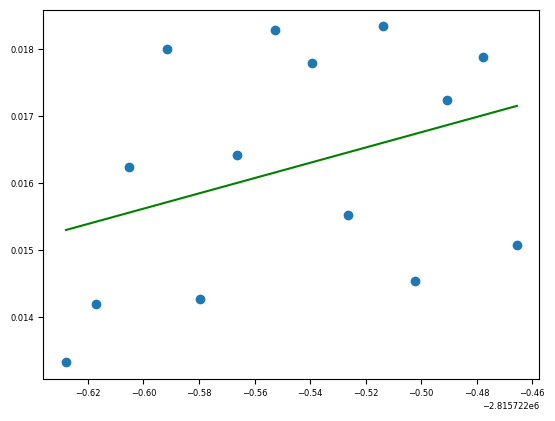

In [181]:
# Criação de um modelo de ajuste polinomial
model1 = np.poly1d(np.polyfit(z_values, w_values, 1))
polyline = np.linspace(min(z_values), max(z_values), 50)

# Geração do grafico
plt.scatter(z_values, w_values)
plt.plot(polyline, model1(polyline), color='green')

#### Exemplo 02. Série de coordenadas. Eliminação da heteroscedasticidade
---
A. Amostragem do conjunto de dados

In [182]:
# Definir coluna "Date" como indexador da Tabela
df_gps_t = df_gps.set_index('Decimal Year')

# Definir o intervalo de tempo para amostragem
df_gps_range = df_gps_t.loc['2008':'2024']

df_gps_range.head()

,Station,Date,MJD,GPS Week,Week Day,Longitude,East,North,Up,Antenna Height,dE,dN,dU,corrEN,corrEU,corrNU,Year
Decimal Year,,,,,,,,,,,,,,,,,
2008.0000,UFPR,08JAN01,54466,1460,2,-49.2,-3113.39851,-2.815723e+06,925.78285,0.1,0.00074,0.00076,0.00311,0.04948,0.01105,0.09435,2008
2008.0027,UFPR,08JAN02,54467,1460,3,-49.2,-3113.39921,-2.815723e+06,925.78353,0.1,0.00076,0.00078,0.00325,0.05720,0.01940,0.11799,2008
2008.0055,UFPR,08JAN03,54468,1460,4,-49.2,-3113.39896,-2.815723e+06,925.77630,0.1,0.00073,0.00076,0.00308,0.09026,0.04110,0.07430,2008
2008.0082,UFPR,08JAN04,54469,1460,5,-49.2,-3113.40123,-2.815723e+06,925.78228,0.1,0.00074,0.00075,0.00309,0.09465,-0.00029,0.08889,2008
2008.0110,UFPR,08JAN05,54470,1460,6,-49.2,-3113.39712,-2.815723e+06,925.77837,0.1,0.00074,0.00076,0.00313,0.07715,-0.01121,0.07901,2008


B. Cálculo do modelo de regressão linear

In [183]:
df_model = ols(formula='North~MJD', data=df_gps_range).fit()

C. Geração de uma função para transformar os dados de Dataframe a Numpy

In [184]:
def test_model(col):
  s = []
  for i in col:
    a = [1,i]
    s.append(a)
  return (np.array(s))

C. Cálculo do Teste de Breusch-Pagan

In [185]:
comp_model = test_model(df_gps_range['North'])

bp_test = het_breuschpagan(df_model.resid, comp_model)

print ('LM-test p_value')
print (bp_test[1])

LM-test p_value
1.3908916104610337e-35


**Interpretação:**

O resultado do *valor p* do teste está muito abaixo do nível de significância, portanto podemos rejeitar a $H_0$ (i.e. os dados são heterocedásticos).

D. Transformação logarítmica

In [186]:
df_gps_range['log_North'] = np.log(df_gps_range['North'])

df_gps_range.head()

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning:

invalid value encountered in log

<ipython-input-186-65334f6a325c>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Station,Date,MJD,GPS Week,Week Day,Longitude,East,North,Up,Antenna Height,dE,dN,dU,corrEN,corrEU,corrNU,Year,log_North
Decimal Year,,,,,,,,,,,,,,,,,,
2008.0000,UFPR,08JAN01,54466,1460,2,-49.2,-3113.39851,-2.815723e+06,925.78285,0.1,0.00074,0.00076,0.00311,0.04948,0.01105,0.09435,2008,NaN
2008.0027,UFPR,08JAN02,54467,1460,3,-49.2,-3113.39921,-2.815723e+06,925.78353,0.1,0.00076,0.00078,0.00325,0.05720,0.01940,0.11799,2008,NaN
2008.0055,UFPR,08JAN03,54468,1460,4,-49.2,-3113.39896,-2.815723e+06,925.77630,0.1,0.00073,0.00076,0.00308,0.09026,0.04110,0.07430,2008,NaN
2008.0082,UFPR,08JAN04,54469,1460,5,-49.2,-3113.40123,-2.815723e+06,925.78228,0.1,0.00074,0.00075,0.00309,0.09465,-0.00029,0.08889,2008,NaN
2008.0110,UFPR,08JAN05,54470,1460,6,-49.2,-3113.39712,-2.815723e+06,925.77837,0.1,0.00074,0.00076,0.00313,0.07715,-0.01121,0.07901,2008,NaN


D.1. Normalização da série (valores positivos)


In [187]:
df_gps_range['norm_North'] = df_gps_range['North'] - (df_gps_range['North'].min() + 0.0001)

df_gps_range['log_North'] = np.log(df_gps_range['norm_North'])

df_gps_range.dropna(inplace=True)

df_gps_range.head()

<ipython-input-187-d0525ef86f89>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning:

invalid value encountered in log

<ipython-input-187-d0525ef86f89>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-187-d0525ef86f89>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

,Station,Date,MJD,GPS Week,Week Day,Longitude,East,North,Up,Antenna Height,dE,dN,dU,corrEN,corrEU,corrNU,Year,log_North,norm_North
Decimal Year,,,,,,,,,,,,,,,,,,,
2008.0000,UFPR,08JAN01,54466,1460,2,-49.2,-3113.39851,-2.815723e+06,925.78285,0.1,0.00074,0.00076,0.00311,0.04948,0.01105,0.09435,2008,-6.692644,0.00124
2008.0027,UFPR,08JAN02,54467,1460,3,-49.2,-3113.39921,-2.815723e+06,925.78353,0.1,0.00076,0.00078,0.00325,0.05720,0.01940,0.11799,2008,-6.515713,0.00148
2008.0055,UFPR,08JAN03,54468,1460,4,-49.2,-3113.39896,-2.815723e+06,925.77630,0.1,0.00073,0.00076,0.00308,0.09026,0.04110,0.07430,2008,-5.516473,0.00402
2008.0082,UFPR,08JAN04,54469,1460,5,-49.2,-3113.40123,-2.815723e+06,925.78228,0.1,0.00074,0.00075,0.00309,0.09465,-0.00029,0.08889,2008,-5.918214,0.00269
2008.0137,UFPR,08JAN06,54471,1461,0,-49.2,-3113.39586,-2.815723e+06,925.78962,0.1,0.00074,0.00077,0.00316,0.07757,0.02085,0.09110,2008,-5.944581,0.00262


D.2. Plotagem da série normalizada

In [188]:
# Ativar "plotly" para geração de gráficos interativos
pd.options.plotting.backend = "plotly"

# Geração da série de coordenadas
fig = df_gps_range.plot(title = "UFPR Continuous Monitoring GNSS Station. North Component", x = 'MJD', y = 'norm_North')

# Apresentar série de tempo
fig.show()

D.3. Cálculo do Teste de Breusch-Pagan

In [189]:
df_model = ols(formula='log_North~MJD', data=df_gps_range).fit()

log_model = test_model(df_gps_range['log_North'])

bp_test = het_breuschpagan(df_model.resid, log_model)

print ('LM-test p_value')
print (bp_test[1])

LM-test p_value
0.0


**Interpretação:**

O resultado do *valor p* do teste está muito abaixo do nível de significância, portanto podemos rejeitar a $H_0$ (i.e. os dados são heterocedásticos).

E. Transformação de Box Cox

E.1. Cálculo do modelo Box Cox

In [190]:
x, _ = stats.boxcox(df_gps_range['norm_North'])

df_gps_range['trans_North'] = x

<ipython-input-190-ea15dd5c4f9c>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



E.2. Cálculo do Teste de Breusch-Pagan

In [191]:
df_model = ols(formula='trans_North~MJD', data=df_gps_range).fit()

trans_model = test_model(df_gps_range['trans_North'])

bp_test = het_breuschpagan(df_model.resid, trans_model)
print ('LM-test p_value')
print (bp_test[1])

LM-test p_value
1.6542021799661598e-81


F. Plotagem das séries

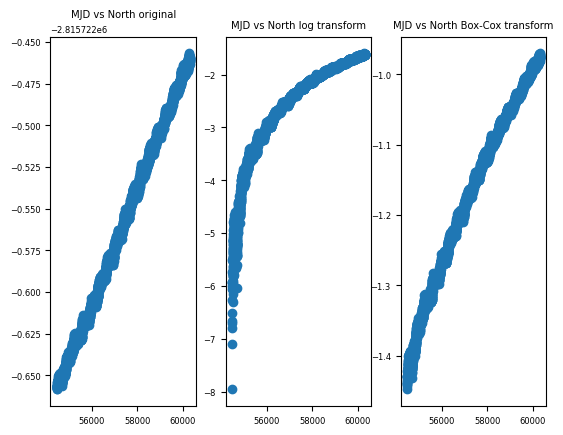

In [192]:
plt.figure()
plt.rcParams.update({'font.size': 6})

plt.subplot(1,3,1)
plt.title('MJD vs North original')
plt.scatter(df_gps_range.MJD, df_gps_range.North)

plt.subplot(1,3,2)
plt.title('MJD vs North log transform')
plt.scatter(df_gps_range.MJD, df_gps_range.log_North)

plt.subplot(1,3,3)
plt.title('MJD vs North Box-Cox transform')
plt.scatter(df_gps_range.MJD, df_gps_range.trans_North)
plt.show()

## **3.3. Estimadores**

Os modelos utilizados para descrever séries temporais são processos estocásticos, isto é, processos controlados por leis probabilísticas.

A construção destes modelos depende de vários fatores, tais como o comportamento do fenômeno ou o conhecimento a priori que temos de sua natureza e do objetivo da análise.

### **3.3.1. Processos estocásticos**

Seja $T$ um conjunto arbitrário de dados. Um *processo estocástico* é uma família $Z=\left\{Z\left ( t \right ),t\cdot \epsilon \cdot T \right\}$, tal que, para cada $t\cdot \epsilon \cdot T$, $Z\left ( t \right )$ é uma variável aleatória.

Nestas condições, um processo estocástico é uma familia de variáveis aleatórias que supomos definidas num mesmo espaço de probabilidades.

<center><img src=https://iili.io/dsv8Vpe.md.jpg width="500"></center>

<center>Fonte: Morettin, P. & Toloi, C. (2014)</center>



### **3.3.2. Especificação de um processo estocástico**

Sejam $t_1$, $t_2$, ...$t_n$ elementos quaisquer de T e consideremos:

$$F(z_{1},\cdots ,z_{n};t_{1},\cdots ,t_{n})=P\left ( Z\left ( t_{1} \right )\leq z_{1},\cdots ,Z\left ( t_{n} \right )\leq z_{n} \right )$$

Então, o processo estocástico $Z=\left\{Z\left ( t \right ),t\cdot \epsilon \cdot T \right\}$ estará especificado se conhecermos as *distribuições finito-dimensionais* para todo $n\geq 1$.

Na prática, não conhecemos todas essas distribuições finito-dimensionais, pelo qual, estuda-se certas características associadas à função $F(z_{1},\cdots ,z_{n};t_{1},\cdots ,t_{n})$ que sejam simples de calcular e interpretar.

Uma maneira comumente utilizada para estudar o processo $Z$ é determinar todos os momentos produtos de ordem $\left ( r_{1},\cdots ,r_{n} \right )$ das variáveis aleatórias $Z\left ( t_{1} \right ),\cdots ,Z\left ( t_{n} \right )$. Ou seja, determinar:

$$\mu \left ( r_{1},\cdots ,r_{n};t_{1},\cdots ,t_{n} \right )=E\left\{ Z^{r_{1}\left ( t_{1} \right )}\cdots Z^{r_{n}\left ( t_{n} \right )} \right\}=\int_{-\infty }^{\infty }\int_{-\infty }^{\infty }z_{1}^{r_{1}}\cdots z_{n}^{r_{n}}f\left ( z_{1},\cdots ,z_{n};t_{1},\cdots ,t_{n} \right )d_{z_{1}}\cdots d_{z_{n}}$$

onde $f\left ( z_{1},\cdots ,z_{n};t_{1},\cdots ,t_{n} \right )$ é a função de probabilidade correspondente a $F(z_{1},\cdots ,z_{n};t_{1},\cdots ,t_{n})$.

Em particular, o que se faz, é restringir o estudo a momentos de baixa ordem, sendo os mais importantes a média:

$$\mu \left ( t \right )=E\left\{Z\left ( t \right ) \right\}$$

e a função de autocovariância:

$$\gamma \left ( t_{1},t_{2} \right )=cov\left\{Z\left ( t_{1} \right ),Z\left ( t_{2} \right ) \right\}$$

**Importante:**

Naquelas situações em que se pretende utilizar modelos para descrever séries temporais, é necessário introduzir suposições simplificadoras, que nos conduza a analisar determinadas classes de processos estocásticos. Entre algumas alternativas temos:

1.   Processos estacionários ou não-estacionários, de acordo com a independência ou não relativamenteà origem dos tempos;
2.   Processos normais (Gaussianos) ou não-normais, de acoro com as funções de probabilidade que caracterizam os processos;
3.   Processos Markovianos ou não-Markovianos, de acordo com a independência dos valores do processo, em dado instante, de seus valores em instantes precedentes.

### **3.3.3. Tipo de estimadores/modelos**

De forma geral, podemos classificar os modelos para séries temporais segundo o número de parâmetros envolvidos da forma:

1. **Modelos paramêtricos** para os quais este número de parâmetros é finito.

 Na clase de modelos e/ou estimadores paramêtricos, a análise e feita no dominio do tempo. Dentre estes modelos os mais usados são: os modelos de erro (ou de regressão), os modelos de suavização exponencial, os modelos auto-regressivos e de médias móveis (ARMA), os modelos auto-regressivos integrados e de médias móveis (ARIMA), modelos de memória longa (ARFIMA), modelos estruturais e modelos não-lineares.

2. **Modelos não-paramêtricos** que envolvem um número infinito de parâmetros.

 Os modelos e/ou estimadores não-paramêtricos mais utilizados são a função de autocovariância (ou autocorrelação) e sua transformada de Fourier, o espectro (i.e. do ponto de vista matemático, estas funções são pares de Fourier e portanto equivalentes).

 A vantagem de se descrever a série no domínio de frequências está no fato de se eliminar o problema de correlação serial, pois na análise espectral os componentes são ortogonais.

### **3.3.4. Modelos de erro ou de regressão**

**3.3.4.1. Modelo de regressão não-paramétrica**

De forma geral, seja:

$$Z_{t}=f\left ( t \right )+a_{t} \rightarrow t=1,\cdots ,N$$

uma série temporal, onde $f\left ( t \right )$ é chamada de *sinal* e $a_{t}$ de ruído.

Se assumirmos que $f\left ( t \right )$ pertence a uma classe particular de funções e quisermos estimar essa função, para todo $t$, teremos um modelo "semi-paramétrico", pois além de $f$, teremos que estimar a variância do ruído $\left\{a_{t} \right\}$. Normalmente, esse problema é denominado de *regressão  não-paramétrica*.

**3.3.4.2. Modelo de regressão paramétrica**

Se no modelo o sinal $f\left ( t \right )$ é uma função do tempo completamente determinada (parte sistemática ou determinística) e $a_t$ é uma sequência aleatória de variáveis não-correlacionadas, independente de $f\left ( t \right )$, com média zero e variância constante. Isto é:

$$\begin{matrix}
E\left ( a_{t} \right )=0, \forall t, & E\left ( a_{t}^{2} \right )=\sigma _{a}^{2}, \forall t, & E\left ( a_{t} a_{s}\right )=0, s\neq t  \\
\end{matrix}$$

o modelo chama-se de *modelo de erro ou de regressão*.

Neste caso:

* Qualquer efeito do tempo influencia somente a parte deterministica $f\left ( t \right )$.
* a série $a_t$ é considerada de *ruido branco* (i.e. observações não-correlacionadas).

**3.3.4.3. Derivações do modelo de regressão**

1.   **Modelo de média constante**

 $$\begin{matrix}
Z_{t}=Q+a_{t} & t=1,\cdots ,N, \\
\end{matrix}$$

 onde $f\left ( t \right )=Q$ é uma constante.

2.   **Modelo de tendência linear**

 $$\begin{matrix}
Z_{t}=\alpha +\beta t+a_{t} & t=1,\cdots ,N, \\
\end{matrix}$$

 onde $f\left ( t \right )=\alpha +\beta t$ é uma função linear dos parâmetros.

3.   **Modelo de regressão**

 $$\begin{matrix}
Z_{t}=\alpha +\beta x_{t}+a_{t} & t=1,\cdots ,N, \\
\end{matrix}$$

 onde $f\left ( t \right )=\alpha +\beta x_{t}$ é uma função linear dos parâmetros, sendo $x_{t}$ uma quantidade (fixa) observável.

 **Importante:** Neste casos, onde $f\left ( t \right )$ é uma função linear dos parâmetros, estes podem ser estimados usando-se o método de mínimos quadrados.

4.   **Modelo de curva de crecimento**

 $$\begin{matrix}
Z_{t}=\alpha +e^{\beta t+a_{t}} & t=1,\cdots ,N, \\
\end{matrix}$$

 Neste caso, $f\left ( t \right )$ não é uma função linear dos parâmetros, embora o seu logaritmo $log\left ( Z_{t} \right )$ o seja.

**3.3.4.4 A função $f\left ( t \right )$**

2 tipos importante de funções para $f\left ( t \right )$ são:

1. Polinômio em t, em geral de grau baixo, da forma:

 $$f\left ( t \right )=\beta _{0}+\beta _{1}t+\cdots +\beta _{m}t^{m}$$

 de modo que a componente sistemática se move lenta, suave e progressivamente no tempo; neste caso $f\left ( t \right )$ representa uma *tendência polinomial determinística de grau m* (i.e. o processo $Z_t$ será não-estacionário, se $m>0$).

2. Polinômio harmônico, ou seja, uma combinação linear de senos e cosenos com coeficientes constantes, da forma:

 $$f\left ( t \right )=\sum_{n=1}^{p}\left\{\alpha _{n}cos\lambda _{n}t+\beta _{n}sen\lambda _{n}t \right\}$$

 com $\lambda _{n}=2\pi \frac{n}{p}$ se $f\left ( t \right )$ tiver periódo $p$.

 O modelo de erro é o modelo clássico na análise de séries geodésicas (i.e. modelo de trajetórias estándar), sendo que $f\left ( t \right )$ é composta da *adição* ou *multiplicação* de ambos os tipos de função:

 * o polinômio em t representará a tendência, e
 * o polinômio harmônico as flutuações cíclicas e as variações sazonais.

 Ou seja:

 $$f\left ( t \right )=T_{t}+S_{t}$$

 de modo que:

 $$Z_{t}=T_{t}+S_{t}+a_{t}$$

 Normalmente, $T_t$ é a componente ciclo-tendência incluindo as flutuaões cíclicas de longo periódo, que não podem ser detectadas com os dados disponíveis, enquanto $S_t$ é a componente sazonal ou anual.

#### Exemplo 03. Série de coordenadas. Modelo de regressão linear
---
A. Importar o conjunto de dados

In [193]:
# Data for analysis
X = df_gps_range.loc[:, ['MJD']]  # features
y = df_gps_range.loc[:, 'norm_North']  # target

B. Construir o modelo

In [194]:
# Train the model
model = sm.OLS(y, sm.add_constant(X))
results = model.fit()

b, m = results.params
print(f"The intercept is {b} and the slope is {m}")

The intercept is -1.8650135206112357 and the slope is 3.423859896326857e-05


C. Resumo do modelo

In [195]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             norm_North   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 3.116e+06
Date:                Tue, 24 Sep 2024   Prob (F-statistic):               0.00
Time:                        03:54:24   Log-Likelihood:                 26432.
No. Observations:                5773   AIC:                        -5.286e+04
Df Residuals:                    5771   BIC:                        -5.285e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.8650      0.001  -1674.999      0.0

### **3.3.5. Modelos de Suavização Exponencial**

Referência principal: analisemacro.com.br (2024)

---

Os métodos de suavização exponencial produzem previsões a partir de médias ponderadas de observações passadas, onde o peso associado a cada observação cai a medida em que se recua mais no tempo. Ou seja, quanto mais recente a observação, maior será seu peso no modelo preditivo.

Entre os principais modelos de suavização tem-se:

1. **Suavização simples**

 O método de suavização exponencial simples (SES) é, como o nome sugere, o mais simples dos métodos, sendo aplicável a dados sem tendência ou sazonalidade com padrão claro.

 Para modelar e prever essa série sem características de tendência ou sazonalidade claras, poderíamos utilizar o método do passeio aleatório, onde todas as previsões para o futuro são iguais ao último valor observado da série:

  $$\hat{y}_{T+h|T} = y_{T}$$

 Dessa forma, o método do passeio aleatório assume que a última observação é a única e mais importante para produzir previsões para a série temporal. Todas as outras observações não possuem importância para prever o futuro. Podemos pensar que esse método é uma média ponderada onde todos os pesos são dados apenas para a última observação.

 Outra possibilidade é prever a série temporal com o método da média, onde todas as previsões para o futuro são iguais à média dos dados observados:

  $$\hat{y}_{T+h|T} = \frac1T \sum_{t=1}^T y_t$$

 Dessa forma, o método da média assume que todas as observações da série temporal possuem igual importância (pesos) para produzir previsões para o futuro.

 Note que estes métodos são dois extremos e, na verdade, queremos um método que é um meio termo. É razoável pensar que pesos maiores devem ser dados para as observações mais recentes do que para observações do passado distante. Esse é o conceito por trás do método de suavização exponencial simples, onde as previsões são geradas utilizando médias ponderadas, onde os pesos decaem exponencialmente (os menores pesos são associados com as observações mais antigas):

  $$\hat{y}_{T+1|T} = \alpha y_T + \alpha(1-\alpha) y_{T-1} + \alpha(1-\alpha)^2 y_{T-2}+ \cdots$$

 onde:

 $0 \le \alpha \le 1$ é o parâmetro de suavização que controla a taxa em que os pesos decaem até as observações mais antigas.

 O método SES pode ser representado pelas equações:

 <center><img src=https://analisemacro.com.br/wp-content/uploads/2023/08/f1-1.png width="400"></center>

 * A equação de previsão diz que a previsão para o período $t + 1$ é o nível estimado para o período $t$.

 * A equação de suavização (ou nível) define a estimativa do nível a cada período $t$.

 Note que esse processo precisa iniciar em algum momento, portanto um valor ótimo de início $\ell_0$ e um valor de $\alpha$ precisa ser escolhido.

 De forma similar a regressão linear, a escolha dos parâmetros ótimos podem ser feita minimizando a soma dos quadrado dos resíduos.

  $$\sum_{t=1}^T(y_t - \hat{y}_{t|t-1})^2=\sum_{t=1}^Te_t^2$$

2. **Método de tendência linear de Holt**

 Para contemplar séries temporais que apresentam tendência, o método de suavização exponencial de tendência linear de Holt foi desenvolvido.

 Para modelar e prever essa série com característica de tendência clara, podemos utilizar o método tendência linear de Holt. Esse método possui uma equação de previsão e duas equações de suavização (uma para o nível e outra para a tendência):

 <center><img src=https://analisemacro.com.br/wp-content/uploads/2023/08/f2-1.png width="450"></center>

 onde:

 $\ell_t$ é o nível estimado da série temporal.

 $b_t$ é a tendência estimada da série temporal.

 $\alpha$ é o parâmetro de suavização para o nível, restrito a $0\le\alpha\le1$.

 $\beta^*$ é o parâmetro de suavização para a tendência, restrito a $0\le\beta^*\le1$.

 Agora a previsão não é mais plana, mas com tendência. A previsão $h$ passos a frente é igual ao último nível estimado mais $h$ vezes a última tendência estimada. Dessa forma, a previsão é uma função linear de $h$.

 Os parâmetros $\alpha$, $\beta^*$, $\ell_0$ e $b_0$ devem ser escolhidos de forma a minimizar o MMQ.

3. **Método de tendência linear amortecida**

 As previsões pelo método de tendência linear de Holt geram uma tendência constante, seja crescente ou decrescente, indefinidamente para o futuro. É razoável pensar que a população, não crescerá indefinidamente como prevê o modelo. Pensando nessa limitação, foi desenvolvido o método de tendência linear amortecida introduzindo um novo parâmetro para “achatar” a linha de tendência para uma linha plana em algum ponto no futuro.

 A representação desse método é por três equações, similar ao método de tendência linear de Holt, com a adição de um parâmetro $0<\phi<1$ para amortecer a linha de tendência:

 <center><img src=https://analisemacro.com.br/wp-content/uploads/2023/08/f3-1.png width="450"></center>

 Se o valor de $\phi = 1$, então esse método é idêntico ao método de tendência linear de Holt. Para valores entre 0 e 1, o parâmetro amortece a linha de tendência para uma linha plana em algum ponto no futuro (pode ser necessário vários passos de previsão para isso acontecer).

 Os parâmetros $\alpha$, $\beta^*$, $\ell_0$, $b_0$ e $\phi$ devem ser escolhidos de forma a minimizar o MMQ.

4. **Método de sazonalidade aditiva de Holt e Winters**

 O método aditivo é preferível quando as variações sazonais são constantes ao longo da série temporal. Nesse caso, o componente sazonal é expresso em valores absolutos na escala dos dados e o nível da série é ajustado sazonalmente subtraindo o componente sazonal.

 A representação desse método é dada por quatro equações:

 <center><img src=https://analisemacro.com.br/wp-content/uploads/2023/08/f4-1.png width="500"></center>

 onde:

 $m$ é a periodicidade da sazonalidade da série temporal (i.e., para dados trimestrais $m = 4$, para mensais $m = 12$).

 $k$ é a parte inteira de $(h - 1)/m$, o que assegura que as estimativas dos índices sazonais utilizadas para previsão são do ano final da amostra.

 $s_t$ é a tendência estimada da série temporal.

 $\gamma$ é o parâmetro de suavização para a sazonalidade, restrito a $0\le\gamma\le 1-\alpha$.

 A equação de nível da série temporal agora tem uma média ponderada entre a série observada ajustada sazonalmente $(y_{t} - s_{t-m})$ e a parte não sazonal da previsão $(\ell_{t-1}+b_{t-1})$.

 A equação de tendência é idêntica ao método de tendência linear de Holt. A equação de sazonalidade é uma média ponderada entre o índice sazonal corrente $(y_{t}-\ell_{t-1}-b_{t-1})$ e o índice sazonal da mesma sazonalidade do ano anterior (m períodos anteriores).

 Os parâmetros $\alpha$, $\beta^*$, $\ell_0$, $b_0$, $\gamma$ e $(s_0, s_1, s_2, \cdots, s_i)$ devem ser escolhidos de forma a maximizar a probabilidad (MLE).

5. **Método de sazonalidade multiplicativa de Holt e Winters**

 O método multiplicativo é preferível quando as variações sazonais mudam proporcionalmente ao nível da série temporal. Nesse caso, o componente sazonal é expresso em valores relativos (porcentagens) e o nível da série é ajustado sazonalmente dividindo pelo componente sazonal.

 A representação desse método é dada por quatro equações:

 <center><img src=https://analisemacro.com.br/wp-content/uploads/2023/08/f5-1.png width="500"></center>

 Os parâmetros $\alpha$, $\beta^*$, $\ell_0$, $b_0$, $\gamma$ e $(s_0, s_1, s_2, \cdots, s_i)$ devem ser escolhidos de forma a maximizar a probabilidad (MLE).

#### Exemplo 04. Série de vendas de shampoo. Modelo de suavização exponencial
---
A. Importar o conjunto de dados

In [261]:
series = pd.read_excel('/content/timeseries/datasets/zemkoho/ShampooSales.xls', sheet_name='Data', header=0, index_col=0, parse_dates=True)

B. Estabelecer o modelo de ajuste e plotar os resultados

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



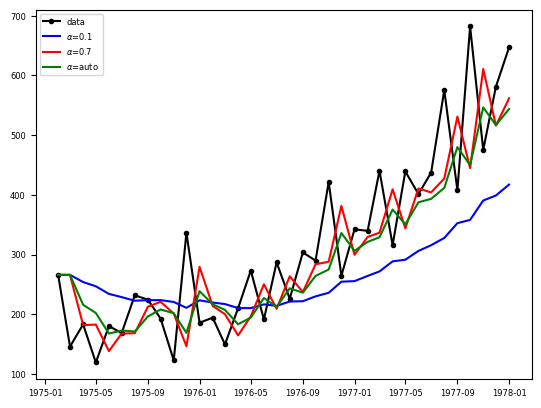

In [286]:
# Simple Exponential Smoothing #

# Plotting the original data together with the 3 forecast plots
plt.plot(series, marker=".", color="black")

## SES model 1: alpha = 0.1
fit1 = SimpleExpSmoothing(series).fit(smoothing_level=0.1,optimized=False)
fcast1 = fit1.forecast(10).rename(r'$\alpha=0.1$')
# Plot of fitted values and forecast of next 10 values, respectively
plt.plot(fit1.fittedvalues, color="blue")
#(line1,) = plt.plot(fcast1, color="blue")

## SES model 2: alpha = 0.7
fit2 = SimpleExpSmoothing(series).fit(smoothing_level=0.7,optimized=False)
fcast2 = fit2.forecast(10).rename(r'$\alpha=0.7$')
# Plot of fitted values and forecast of next 10 values, respectively
plt.plot(fit2.fittedvalues, color="red")
#(line2,) = plt.plot(fcast2, color="red")

## SES model 3: alpha automatically selected by the built-in optimization software
fit3 = SimpleExpSmoothing(series).fit()
fcast3 = fit3.forecast(10).rename(r'$\alpha=%s$'%fit3.model.params['smoothing_level'])
# Plot of fitted values and forecast of next 10 values, respectively
plt.plot(fit3.fittedvalues, color="green")
#(line3,) = plt.plot(fcast3, color="green")

## Plot legend
plt.legend(['data', r'$\alpha$=0.1',r'$\alpha$=0.7',r'$\alpha$=auto'])

C. Cálculo dos erros dos modelos

In [271]:
#Evaluating the errors
MSE1=mean_squared_error(fit1.fittedvalues, series)
MSE2=mean_squared_error(fit2.fittedvalues, series)
MSE3=mean_squared_error(fit3.fittedvalues, series)

print('Summary of errors resulting from SES models 1, 2 & 3:')
cars = {'Model': ['MSE'],
        'SES model 1': [MSE1],
        'SES model 2': [MSE2],
        'SES model 3': [MSE3]
        }
AllErrors = pd.DataFrame(cars, columns = ['Model', 'SES model 1', 'SES model 2', 'SES model 3'])
print(AllErrors)

Summary of errors resulting from SES models 1, 2 & 3:
  Model   SES model 1  SES model 2  SES model 3
0   MSE  13349.118229  8032.361276  6878.753714


#### Exemplo 05. Série de coordenadas. Modelo de suavização exponencial
---
A. Importar o conjunto de dados

In [272]:
df_gps_north = df_gps_range[['North']].copy()

B. Estabelecer o modelo de ajuste e plotar os resultados

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/b

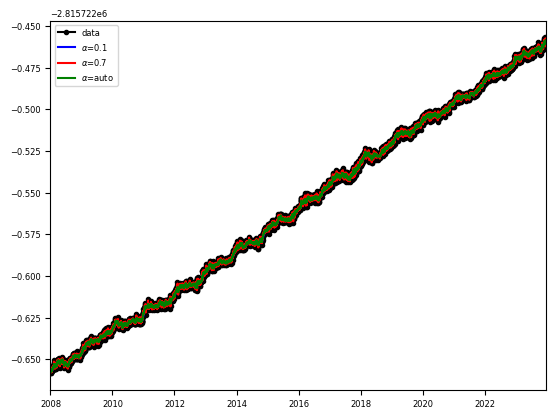

In [287]:
# Simple Exponential Smoothing #

# Plotting the original data together with the 3 forecast plots
plt.plot(df_gps_north, marker=".", color="black")

## SES model 1: alpha = 0.1
fit1 = SimpleExpSmoothing(df_gps_north).fit(smoothing_level=0.1,optimized=False)
fcast1 = fit1.forecast(10).rename(r'$\alpha=0.1$')
# Plot of fitted values and forecast of next 10 values, respectively
plt.plot(fit1.fittedvalues, color="blue")
#(line1,) = plt.plot(fcast1, color="blue")

## SES model 2: alpha = 0.7
fit2 = SimpleExpSmoothing(df_gps_north).fit(smoothing_level=0.7,optimized=False)
fcast2 = fit2.forecast(10).rename(r'$\alpha=0.7$')
# Plot of fitted values and forecast of next 10 values, respectively
plt.plot(fit2.fittedvalues, color="red")
#(line2,) = plt.plot(fcast2, color="red")

## SES model 3: alpha automatically selected by the built-in optimization software
fit3 = SimpleExpSmoothing(df_gps_north).fit()
fcast3 = fit3.forecast(10).rename(r'$\alpha=%s$'%fit3.model.params['smoothing_level'])
# Plot of fitted values and forecast of next 10 values, respectively
plt.plot(fit3.fittedvalues, color="green")
#(line3,) = plt.plot(fcast3, color="green")

# Plot legend and axis
plt.xlim(df_gps_north.index.min(),df_gps_north.index.max())
plt.legend(['data', r'$\alpha$=0.1',r'$\alpha$=0.7',r'$\alpha$=auto'])

C. Cálculo dos erros dos modelos

In [288]:
#Evaluating the errors
from sklearn.metrics import mean_squared_error
MSE1=mean_squared_error(fit1.fittedvalues, df_gps_north)
MSE2=mean_squared_error(fit2.fittedvalues, df_gps_north)
MSE3=mean_squared_error(fit3.fittedvalues, df_gps_north)

print('Summary of errors resulting from SES models 1, 2 & 3:')
import pandas as pd
cars = {'Model': ['MSE'],
        'SES model 1': [MSE1],
        'SES model 2': [MSE2],
        'SES model 3': [MSE3]
        }
AllErrors = pd.DataFrame(cars, columns = ['Model', 'SES model 1', 'SES model 2', 'SES model 3'])
print(AllErrors)

Summary of errors resulting from SES models 1, 2 & 3:
  Model  SES model 1  SES model 2  SES model 3
0   MSE     0.000002     0.000002     0.000002
